In [1]:
import numpy as np
import os
from skimage import io
from unet_master.model import *
from unet_master.data import *

C:\Users\clmvandenheuve\Anaconda3\envs\tenv\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def crop_img(P, w, ol):
    '''
    This function find the limits of an image dimension s.t. tiles fit inside it.
    The operation is done for one dimension only.
    P = number of pixels of the input image, in one dimension.
    w = width of tile (e.g. 512).
    ol = overlap of tiles (e.g. 100 pixels)
    '''
    
    numtiles = (P - w) / (w - ol)
    numtiles_rounded = np.floor(numtiles)
    
    num_included = numtiles_rounded * (w - ol) + w 
    num_cropped = P - num_included
    
    # Notify the user if more than 25 pixels are cropped on both sides:
    if num_cropped > 50:
        print("WARNING: You are losing more than 25 pixels on both sides of the image.\n Check your image afterwards to see if it still contains the whole well.\n")    
    
    # calculate margins (min and max)
    m_min = np.floor(num_cropped / 2)
    m_max = num_cropped - m_min
    
    min_ = int(m_min)
    max_ = int(P - m_max)
    
    return min_, max_, numtiles_rounded+1

In [3]:
def create_tiles(cropped_ch, xnumtiles, ynumtiles, w, ol):
    '''
    Create tiles with overlap.
    '''
    xtile_positions = np.arange(0, xnumtiles) * (w - ol)
    ytile_positions = np.arange(0, ynumtiles) * (w - ol)
    
    tiles = []
    for x in xtile_positions:
        for y in ytile_positions:
            x = int(x)
            y = int(y)
            tiles.append(cropped_ch[y:y+512, x:x+512])
            
    return tiles

In [4]:
# Create tiles
w = 512
ol = 100
root = 'Data\\WKS023\\2020-09-09'
well = 'B03'

well_folder = os.path.join(root, 'well '+well)
img_path = os.path.join(well_folder, well + '_fused.tif')
img = io.imread(img_path)
print('Read the image')

ch_MEM = img[:,:,0] / np.max(img[:,:,0])
ch_DAPI = img[:,:,2] / np.max(img[:,:,2])

N,M = ch_MEM.shape

xmin, xmax, xnumtiles = crop_img(M, w, ol)
ymin, ymax, ynumtiles = crop_img(N, w, ol)
cr_MEM = ch_MEM[ymin:ymax, xmin:xmax]
tiles = create_tiles(cr_MEM, xnumtiles, ynumtiles, w, ol)

Read the image


In [5]:
# get model
model_name = '20201002_hela_s1e300b2.hdf5'
model_path = os.path.join('unet_master', model_name)
num_test_images = len(tiles)

In [6]:
# predict the tiles
model = unet(pretrained_weights = model_path)
testGene = predictGenerator(tiles)
results = model.predict_generator(testGene, num_test_images, verbose=1)
#saveResult(predict_path, results)

N:\tnw\BN\dm\Shared\Lukas\Lukas vd Heuvel\unet_master\model.py:55: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("co..., inputs=Tensor("in...)`
  model = Model(input = inputs, output = conv10)
C:\Users\clmvandenheuve\Anaconda3\envs\tenv\lib\site-packages\skimage\transform\_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\clmvandenheuve\Anaconda3\envs\tenv\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


441/441 [==============================] - 32s 74ms/step


In [7]:
# combine predicted tiles into cols

rg = np.linspace(0,1,ol).reshape(ol,1)
vert_combiner_bottom = np.vstack( (np.matlib.repmat(rg,1,w), np.ones((w-ol, w))) )
vert_combiner_top = np.vstack( ( np.ones((w-ol, w)), np.matlib.repmat(np.flipud(rg),1,w)) )
vert_combiner_center = np.vstack( ( (np.matlib.repmat(rg,1,w), np.ones((w-2*ol, w)), np.matlib.repmat(np.flipud(rg),1,w)) ) )

xtile_positions = np.arange(0, xnumtiles) * (w - ol)
ytile_positions = np.arange(0, ynumtiles) * (w - ol)

Ncr, Mcr = cr_MEM.shape
col_list = []
c = 0
for x in xtile_positions:
    col = np.zeros((Ncr, 512))
    for y in ytile_positions:
        x = int(x)
        y = int(y)
        
        pred = results[c].reshape(w,w)
        pred = pred / np.max(pred)
        nbh = col[y:y+w,:]
        if y==0:
            nbh = nbh + vert_combiner_top * pred
        elif y==ytile_positions[-1]:
            nbh = nbh + vert_combiner_bottom * pred
        else:
            nbh = nbh + vert_combiner_center * pred
            
        col[y:y+w,:] = nbh
        c = c + 1
            
    col_list.append(col)


In [8]:
# combine cols into full image

rg = np.linspace(0,1,ol).reshape(1,ol)
hor_combiner_right = np.hstack( (np.matlib.repmat(rg,Ncr,1), np.ones((Ncr, w-ol))) )
hor_combiner_left = np.hstack( (np.ones((Ncr, w-ol)), np.matlib.repmat(np.fliplr(rg),Ncr,1)) )
hor_combiner_center = np.hstack( (np.matlib.repmat(rg,Ncr,1), np.ones((Ncr, w-2*ol)), np.matlib.repmat(np.fliplr(rg),Ncr,1)) )

pred_MEM = np.zeros((Ncr,Mcr))
c = int(0)
for x in xtile_positions:
    x = int(x)
    nbh = pred_MEM[:,x:x+w]
    if x==0:
        nbh = nbh + hor_combiner_left*col_list[c]
    elif x==xtile_positions[-1]:
        nbh = nbh + hor_combiner_right*col_list[c]
    else:
        nbh = nbh + hor_combiner_center*col_list[c]
    pred_MEM[:,x:x+w] = nbh
    c = c+1

C:\Users\clmvandenheuve\Anaconda3\envs\tenv\lib\site-packages\skimage\util\dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))


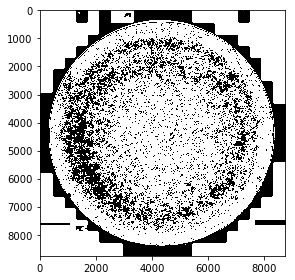

In [9]:
# save the image
from skimage import img_as_ubyte
pred_MEM = pred_MEM / np.max(pred_MEM)
io.imshow(pred_MEM>0.5)
io.imsave(os.path.join(well_folder, well+'_predicted.png'), pred_MEM)